# Import Required Libraries

In [28]:
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# To import overbalanced data
from scipy.sparse import load_npz

# Data balancing
from imblearn.over_sampling import SMOTE

# Sklearn libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
)

# NLTK libraries
import nltk
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, word_tokenize
import contractions

# NLTK resource downloads
nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package words to /Users/jonathan/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jonathan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jonathan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jonathan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load in Datasets


In [31]:
def load_file(filepath):
    return pd.read_csv(filepath, header=None)

In [32]:
# Training df
df_train = load_file('raw_data/fulltrain.csv')
df_train = df_train.set_axis(['label', 'text'], axis=1)

# Testing df
df_test = load_file('raw_data/balancedtest.csv')
df_test = df_test.set_axis(['label', 'text'], axis=1)

# Map the labels

In [33]:
label_mapping = {
    1: "Satire",
    2: "Hoax",
    3: "Propaganda",
    4: "Reliable News"
}
df_train['label'] = df_train['label'].map(label_mapping)
df_test['label'] = df_test['label'].map(label_mapping)

# Verify datasets loaded in correctly

In [34]:
df_train.head(10) # Training set

,label,text
0,Satire,"A little less than a decade ago, hockey fans w..."
1,Satire,The writers of the HBO series The Sopranos too...
2,Satire,Despite claims from the TV news outlet to offe...
3,Satire,After receiving 'subpar' service and experienc...
4,Satire,After watching his beloved Seattle Mariners pr...
5,Satire,"At a cafeteria-table press conference Monday, ..."
6,Satire,Stunned shock and dismay were just a few of th...
7,Satire,"Speaking with reporters before a game Monday, ..."
8,Satire,Sports journalists and television crews were p...
9,Satire,"SALEM, VAF;or the eighth straight world-histor..."


In [35]:
df_test.head(10) # Test set

,label,text
0,Satire,When so many actors seem content to churn out ...
1,Satire,In what football insiders are calling an unex...
2,Satire,In a freak accident following Game 3 of the N....
3,Satire,North Koreas official news agency announced to...
4,Satire,The former Alaska Governor Sarah Palin would b...
5,Satire,With the first Presidential debate just two da...
6,Satire,"There are fans, and then there are super-fans...."
7,Satire,"With its landmark decisions this week, the Uni..."
8,Satire,Koch Industries is defending its acquisition o...
9,Satire,Republican lawmakers asked increasingly tough ...


# Label distribution

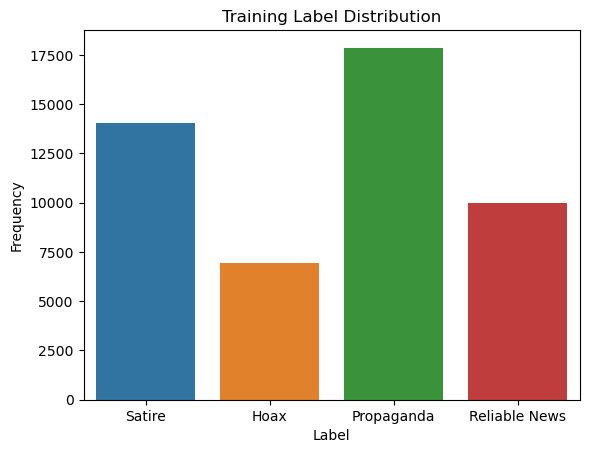

label
Propaganda       17870
Satire           14047
Reliable News     9995
Hoax              6942
Name: count, dtype: int64

In [36]:
sns.countplot(x='label', data=df_train)
plt.title('Training Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()
df_train["label"].value_counts()

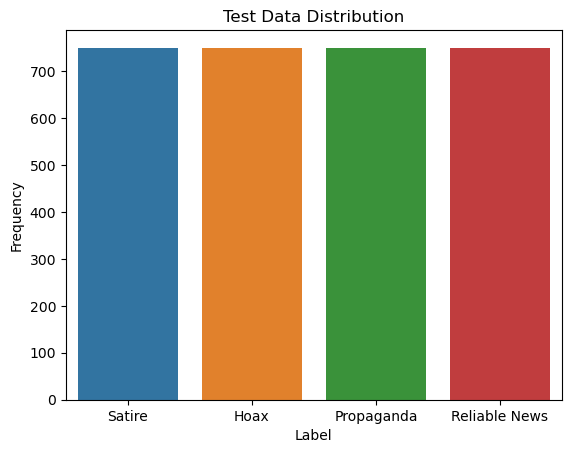

label
Satire           750
Hoax             750
Propaganda       750
Reliable News    750
Name: count, dtype: int64

In [37]:
sns.countplot(x='label', data=df_test)
plt.title('Test Data Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()
df_test["label"].value_counts()

# Basic Text Preprocessing

## Expand Contractions

In [38]:
def expand_contractions(corpus):
    return contractions.fix(corpus)

## Removal of Stop Words

In [39]:
def remove_stopwords(corpus):
    stop = nltk.corpus.stopwords.words('english')
    sentence = ""
    for word in corpus.split():
        if word not in stop:
            sentence += word
            sentence += " "
    return sentence.strip()

## Lemmitization with WordNetLemmitizer

In [40]:
def lemmatize_word(corpus):
    lemma = WordNetLemmatizer()
    sentence = ""
    for word in corpus.split():
        sentence += lemma.lemmatize(word)
        sentence += " "
    return sentence.strip()

## Preprocess the text

In [41]:
def preprocess_text(text):
    text_contractions_expanded = expand_contractions(text)
    text_no_stopwords = remove_stopwords(text_contractions_expanded)
    text_processed = lemmatize_word(text_no_stopwords)
    return text_processed

In [42]:
# Processing datasets
print("Processing dataset: df_train")
df_train['processed_text'] = df_train['text'].apply(preprocess_text)
print("Finished processing dataset: df_train")

print("Processing dataset: df_test")
df_test['processed_text'] = df_test['text'].apply(preprocess_text)
print("Finished processing dataset: df_test")

Processing dataset: df_train
Finished processing dataset: df_train
Processing dataset: df_test
Finished processing dataset: df_test


# Model training and evaluation

In [17]:
# Training set
X_train = df_train['processed_text']
y_train = df_train['label']

# Testing set
X_test = df_test['processed_text']
y_test = df_test['label']

## Choose a Vectorizer

In [52]:
# Choose the appropriate vectorizer here
# vectorizer = CountVectorizer(max_features = 10000)
# vectorizer = TfidfVectorizer(max_features = 10000)
vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_features = 10000)

## Vectorize

In [53]:
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

## Oversampling

### For generating new files

In [27]:
# Only use this when you need to generate new files

# smote = SMOTE(random_state=42)
# X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train_counts, y_train)

# Saving the sparse matrix (X_train_oversampled) to an NPZ file
# save_npz('X_train_ioversampled_nsert_type_here.npz', X_train_oversampled)

# # If y_train_oversampled is a pandas Series, convert it to a numpy array before saving
# # This step ensures compatibility and space efficiency
# y_train_oversampled_np = y_train_oversampled.to_numpy() if hasattr(y_train_oversampled, 'to_numpy') else y_train_oversampled

# # Saving the labels (y_train_oversampled) to an NPY file
# np.save('y_train_oversampled_insert_type_here.npy', y_train_oversampled_np)


## Load in pre-oversampled data

In [54]:
# Bow 
X_train_oversampled_bow = load_npz('raw_data/X_train_oversampled_bow.npz')
y_train_oversampled_bow = np.load('raw_data/y_train_oversampled_bow.npy', allow_pickle=True)

# TfIdf
X_train_oversampled_tfidf = load_npz('raw_data/X_train_oversampled_tfidf.npz')
y_train_oversampled_tfidf= np.load('raw_data/y_train_oversampled_tfidf.npy', allow_pickle=True)

# # TfIdf with n_grams
X_train_oversampled_tfidf_ngrams = load_npz('raw_data/X_train_oversampled_tfidf_ngrams.npz')
y_train_oversampled_tfidf_ngrams = np.load('raw_data/y_train_oversampled_tfidf_ngrams.npy', allow_pickle=True)

## Multinomial Naive Bayes baseline

In [55]:
# Naive Bayes classifier
clf = MultinomialNB()

# Fit the correct oversampled training set depending on your vectorizer
clf.fit(X_train_oversampled_tfidf_ngrams, y_train_oversampled_tfidf_ngrams)

# Predict
y_pred = clf.predict(X_test_counts)

# Score
print(classification_report(y_test, y_pred))

macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f'Macro F1 Score: {macro_f1:.3f}')

               precision    recall  f1-score   support

         Hoax       0.64      0.63      0.63       750
   Propaganda       0.73      0.85      0.78       750
Reliable News       0.84      0.77      0.80       750
       Satire       0.63      0.59      0.61       750

     accuracy                           0.71      3000
    macro avg       0.71      0.71      0.71      3000
 weighted avg       0.71      0.71      0.71      3000

Macro F1 Score: 0.707


## Plot the confusion matrix 

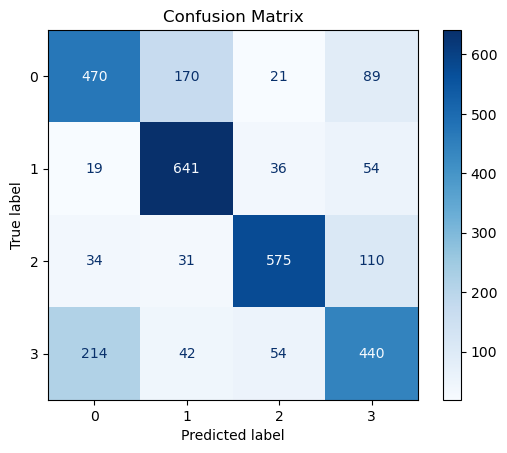

In [56]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## REPLACE WITH YOUR MODEL

In [46]:
## TODO